In [81]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
from random import shuffle, seed
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, \
    Dropout, Input, concatenate, Add, UpSampling2D, Conv2DTranspose

from model import *
from helper_functions import plot_segment, dsc, resize_image
print("TensorFlow Version: ", tf.__version__) 

#### Parameters
H = W = 256
batch_size = 16

TensorFlow Version:  2.1.0


## Load Data

In [6]:
# path
input_folder = './ISIC2018_Task1-2_Training_Input_x2'
output_folder = './ISIC2018_Task1_Training_GroundTruth_x2'
# image name
input_images = sorted([input_folder+'/'+file for file in os.listdir(input_folder) if file.endswith('jpg')])
output_images = sorted([output_folder+'/'+file for file in os.listdir(output_folder) if file.endswith('png')])
assert len(input_images)==len(output_images), 'input and output lists have different length'

# split into train, validatate and test
idx = list(range(len(input_images)))
seed(111)
shuffle(idx)
train_idx = idx[:1600]
validate_idx = idx[1600:2100]
test_idx = idx[2100:]
print(f'train, validate, test set have length: {len(train_idx)}, {len(validate_idx)}, {len(test_idx)}')

# train, test, validate images file name
train_input_images = [input_images[i] for i in train_idx]
train_output_images = [output_images[i] for i in train_idx]
validate_input_images = [input_images[i] for i in validate_idx]
validate_output_images = [output_images[i] for i in validate_idx]
test_input_images = [input_images[i] for i in test_idx]
test_output_images = [output_images[i] for i in test_idx]

train, validate, test set have length: 1600, 500, 494


In [19]:
# read images into numpy array
X_train = [resize_image(mpimg.imread(img)/255,H,W) for img in train_input_images]
X_train = np.array(X_train)
y_train = [resize_image(mpimg.imread(img)[:,:,np.newaxis],H,W) for img in train_output_images]
y_train = np.array(y_train)
X_val = [resize_image(mpimg.imread(img)/255,H,W) for img in validate_input_images]
X_val = np.array(X_val)
y_val = [resize_image(mpimg.imread(img)[:,:,np.newaxis],H,W) for img in validate_output_images]
y_val = np.array(y_val)
X_test = [resize_image(mpimg.imread(img)/255,H,W) for img in test_input_images]
X_test = np.array(X_test)
y_test = [resize_image(mpimg.imread(img)[:,:,np.newaxis],H,W) for img in test_output_images]
y_test = np.array(y_test)

## Build and Train Model

In [84]:
#### Build Model
model = improved_unet(H, W)
#model.summary()

#### Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dsc, 'accuracy'])

#### Train
model_callback=tf.keras.callbacks.ModelCheckpoint(filepath='best_checkpoint',
                                              save_best_only= True,
                                              save_weights_only=True,
                                              monitor = 'val_accuracy',
                                              mode='max')
           
history = model.fit(x = X_train, y=y_train, epochs=30, verbose=1,
                    validation_data=(X_val, y_val), batch_size = batch_size, callbacks=[model_callback])

Train on 1600 samples, validate on 500 samples
Epoch 1/30
1600/1600 [==============================] - 21s 13ms/sample - loss: 5.7320 - dsc: 0.5115 - accuracy: 0.7832 - val_loss: 0.3870 - val_dsc: 0.6631 - val_accuracy: 0.8664
Epoch 2/30
1600/1600 [==============================] - 17s 11ms/sample - loss: 0.2660 - dsc: 0.6892 - accuracy: 0.9050 - val_loss: 0.2711 - val_dsc: 0.7197 - val_accuracy: 0.9050
Epoch 3/30
1600/1600 [==============================] - 17s 11ms/sample - loss: 0.2335 - dsc: 0.7180 - accuracy: 0.9136 - val_loss: 0.2444 - val_dsc: 0.7449 - val_accuracy: 0.9130
Epoch 4/30
1600/1600 [==============================] - 17s 11ms/sample - loss: 0.2034 - dsc: 0.7426 - accuracy: 0.9218 - val_loss: 0.2409 - val_dsc: 0.7513 - val_accuracy: 0.9100
Epoch 5/30
1600/1600 [==============================] - 17s 11ms/sample - loss: 0.1858 - dsc: 0.7602 - accuracy: 0.9272 - val_loss: 0.2592 - val_dsc: 0.7427 - val_accuracy: 0.9027
Epoch 6/30
1600/1600 [==============================]

## Plot trainning history

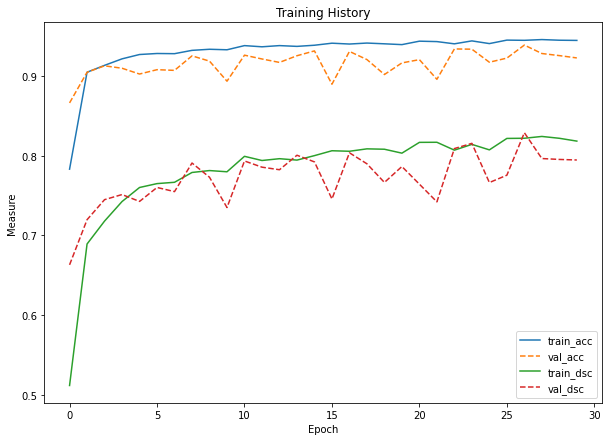

In [85]:
plt.figure(figsize= (10,7))
plt.plot(history.history['accuracy'], label = 'train_acc')
plt.plot(history.history['val_accuracy'], label = 'val_acc', linestyle='dashed')
plt.plot(history.history['dsc'], label = 'train_dsc')
plt.plot(history.history['val_dsc'], label = 'val_dsc', linestyle='dashed')
plt.title('Training History')
plt.ylabel('Measure')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

## Get the best model weights

In [86]:
model.load_weights('best_checkpoint')

## Calculate Avg DSC

In [87]:
#### Test: Calculate Average Dice Similarity
image_dsc = []
s = 0
for i in range(len(test_input_images)):
        img = X_test[i][np.newaxis,:,:,:]
        pred = model.predict(img)
        predd = tf.math.round(pred)
        i_dsc = dsc(predd[0], y_test[i]).numpy()
        s += i_dsc
        image_dsc.append((i_dsc, i))
avg = s/len(test_input_images)
print('Average DSC: ',avg)

#### Plot
image_dsc.sort()

Average DSC:  0.8392553149726287


## Plot Good Predictions

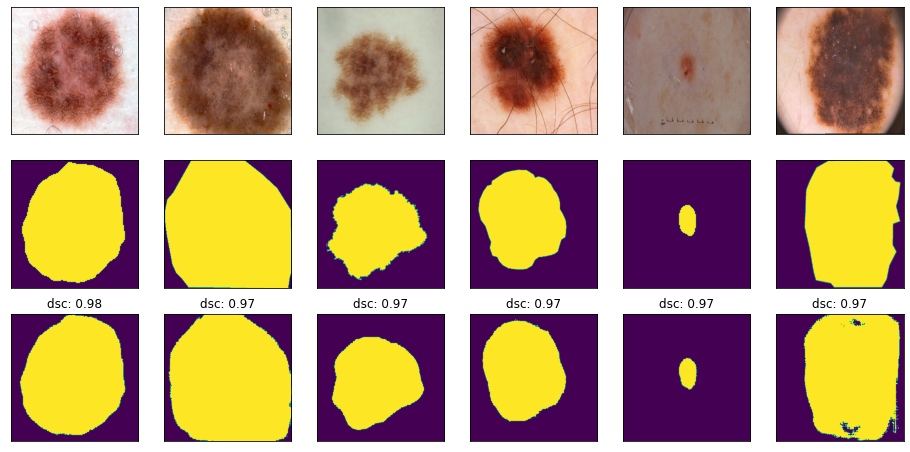

In [93]:
a = 1
high_dsc_images_X = [X_test[idx] for dsc,idx in image_dsc[-a:(-a-7):-1]]
high_dsc_images_y = [y_test[idx] for dsc,idx in image_dsc[-a:(-a-7):-1]]
high_dsc = [dsc for dsc,idx in image_dsc[-a:(-a-7):-1]]
plot_segment(model, high_dsc_images_X, high_dsc_images_y, high_dsc)

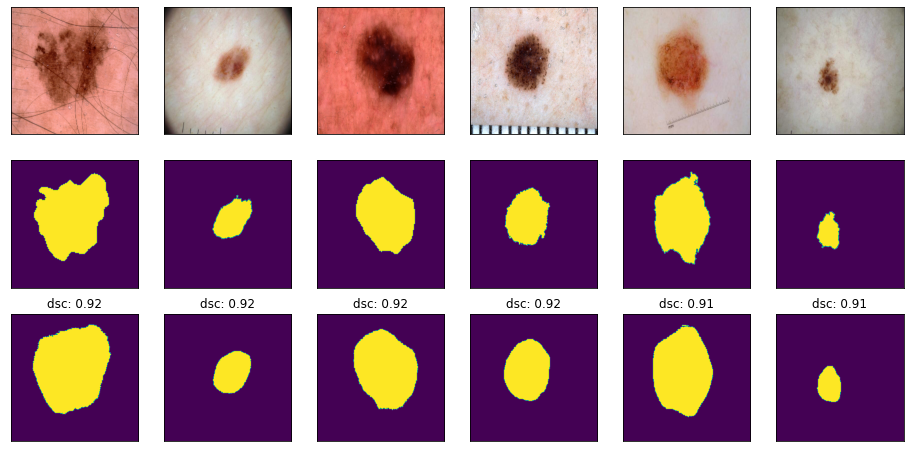

In [94]:
a = 200
high_dsc_images_X = [X_test[idx] for dsc,idx in image_dsc[-a:(-a-7):-1]]
high_dsc_images_y = [y_test[idx] for dsc,idx in image_dsc[-a:(-a-7):-1]]
high_dsc = [dsc for dsc,idx in image_dsc[-a:(-a-7):-1]]
plot_segment(model, high_dsc_images_X, high_dsc_images_y, high_dsc)

## Plot Bad Predictions

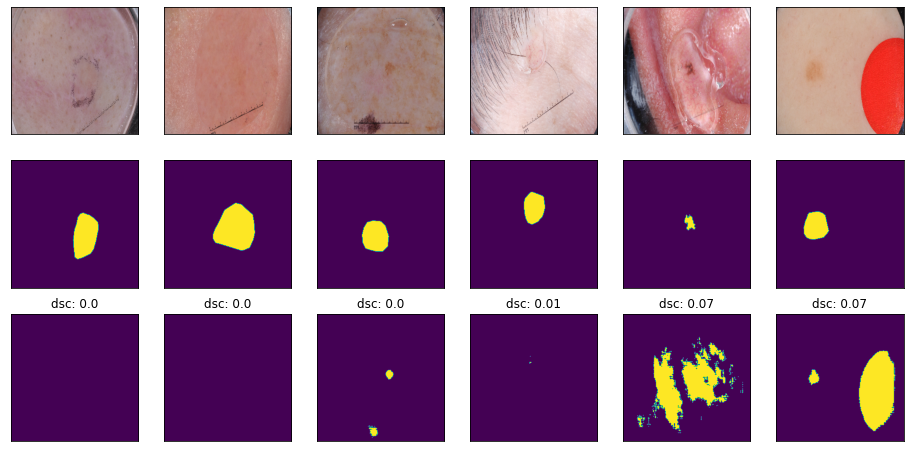

In [89]:
b = 0
low_dsc_images_X = [X_test[idx] for dsc,idx in image_dsc[b:(b+7)]]
low_dsc_images_y = [y_test[idx] for dsc,idx in image_dsc[b:(b+7)]]
low_dsc = [dsc for dsc,idx in image_dsc[b:(b+7)]]
plot_segment(model, low_dsc_images_X, low_dsc_images_y, low_dsc)

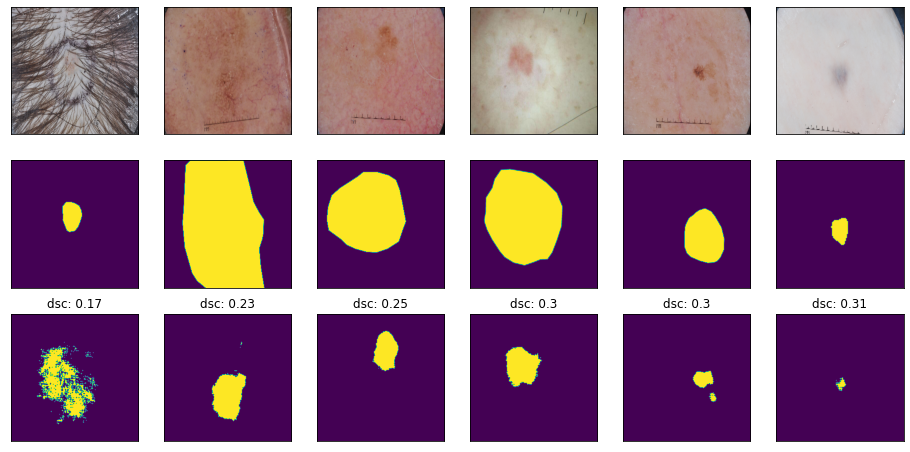

In [90]:
b = 10
low_dsc_images_X = [X_test[idx] for dsc,idx in image_dsc[b:(b+7)]]
low_dsc_images_y = [y_test[idx] for dsc,idx in image_dsc[b:(b+7)]]
low_dsc = [dsc for dsc,idx in image_dsc[b:(b+7)]]
plot_segment(model, low_dsc_images_X, low_dsc_images_y, low_dsc)